# picd : Python Implementation of Causal Discovery

Causal discovery의 주 목적은 우리가 모르는 DAG를 찾아내는 것이다. 이를 위해 우리는 변수들 간의 독립성을 검정하고, 그 검정 결과를 d-separation에 대응시켜서 DAG 또는 DAG 패턴을 찾아낸다. 이 과정에서 두 가지 주의할 점이 있다. 하나는 Faithfulness와 관련된 내용이고, 나머지 하나는 독립성 검정에 대한 내용이다.

##  Conditional_mutual_information_test

### def picd.causal_discovery.test.conditional_mutual_information_test(data:pd.DataFrame, X:set, Y:set, Z:set = None, alpha:float = 0.05, delta:float = None) -> bool

#### Source Code

In [ ]:
def conditional_mutual_information_test(data:pd.DataFrame, X:set, Y:set, Z:set = None, alpha:float = 0.05, delta:float = None) -> bool:
    def conditional_mutual_information(data, X:set, Y:set, Z:set):
        X = list(X); Y = list(Y); Z = list(Z)
        cmi = 0

        P_Z = data.groupby(Z).size()
        P_Z = P_Z/P_Z.sum()

        P_XZ = data.groupby(X + Z).size()
        P_XZ = P_XZ/P_XZ.sum()

        P_YZ = data.groupby(Y + Z).size()
        P_YZ = P_YZ/P_YZ.sum()

        P_XYZ = data.groupby(X + Y + Z).size()
        P_XYZ = P_XYZ/P_XYZ.sum()

        for ind in P_XYZ.index:
            x_ind = ind[:len(X)]
            y_ind = ind[len(X):len(X + Y)]
            z_ind = ind[len(X + Y):]

            xz_ind = x_ind + z_ind
            yz_ind = y_ind + z_ind
            xyz_ind = ind

            z_ind =  pd.MultiIndex.from_tuples([z_ind], names = Z) if len(Z) != 1 else pd.Index(z_ind, name = Z[0])
            xz_ind = pd.MultiIndex.from_tuples([xz_ind], names = X + Z)
            yz_ind = pd.MultiIndex.from_tuples([yz_ind], names = Y + Z)
            xyz_ind = pd.MultiIndex.from_tuples([xyz_ind], names = X + Y + Z)

            cmi += delta * P_XYZ[xyz_ind].item() * np.log2(P_Z[z_ind].item() * P_XYZ[xyz_ind].item() / (P_XZ[xz_ind].item() * P_YZ[yz_ind].item()))

        return cmi
    
    def mutual_information(data, X:set, Y:set):
        X = list(X); Y = list(Y)
        mi = 0

        P_X = data.groupby(X).size()
        P_X = P_X/P_X.sum()

        P_Y = data.groupby(Y).size()
        P_Y = P_Y/P_Y.sum()
        

        P_XY = data.groupby(X + Y).size()
        P_XY = P_XY/P_XY.sum()


        for ind in P_XY.index:
            x_ind = ind[:len(X)]
            y_ind = ind[len(X):]
            xy_ind = [ind]

            x_ind =  pd.MultiIndex.from_tuples([x_ind], names = X) if len(X) != 1 else pd.Index(x_ind, name = X[0])
            y_ind =  pd.MultiIndex.from_tuples([y_ind], names = Y) if len(Y) != 1 else pd.Index(y_ind, name = Y[0])
            xy_ind = pd.MultiIndex.from_tuples(xy_ind, names = X + Y)

            mi += delta * P_XY[xy_ind].item() * np.log2(P_XY[xy_ind].item()/(P_X[x_ind].item() * P_Y[y_ind].item()))

        return mi

    if delta is not None:
      data = data.loc[:, list(X|Y|Z)].round(-math.floor(np.log10(delta))) # 이거 작동하는지 확인인
    else: delta = 1

    if Z:
        mi = conditional_mutual_information(data, X, Y, Z)
    else:
        mi = mutual_information(data, X, Y)
    
    return mi < alpha

## KCIT, Kernel based Conditional Independence Test

### def picd.causal_discovery.test.kcit(data:pd.DataFrame, X:set, Y:set, Z:set = None, regulation:float = 1e-3, alpha:float = 0.05, **test_kwarg) -> bool

경험적으로 가장 성능이 좋은 test

#### Pseudo Code



```
def KCIT(data:pd.DataFrame, X:set, Y:set, Z:set = None, regulation:float = 1e-3, alpha:float = 0.05) -> bool:
	if Z is empty:
		Kx, Ky <- centralized kernel matrix of X, Y 
(메디안에 width 나눈 거, 200 미만 0.8, 1200 이상 0.3 그외 0.5)

		T = Tr(KxKy)/n
		E_T = Tr(Kx) * Tr(Ky) / n^2
		V_T = 2 * Tr(Kx^2) * Tr(Ky^2) / n^4
		
	else:
		X <- (X, Z)
		Kx, Ky, Kz <- centralized kernel matrix of X, Y, Z
		Rz = e * inv(Kz + e*I)
		Kx|z, Ky|z = RzKxRz, RzKyRz
		
		Lx|z <- sorted eigenvalues, denoted by Lx|z[i], of Kx|z (descending order)
		Vx <- a n x n matrix whose i-th column is sqrt(Lx|z[i]) * v 
						where v is the eigenvector correspond to Lx|z[i]
		(resp. Ly|z, Vy)

		W = diag(Vx(Vy.T))
		W = W(W.T)

		T = Tr(Kx|zKy|z)/n
		E_T = Tr(W)/n
		V_T = 2 * Tr(W^2)/n^2

	k = E_T ^ 2 /V_T
	theta = V_T/E_T

	Gamma(k, theta) <- approximated pdf of r.v. T
	p <- p-value of observed T on Gamma(k, theta)

	return p > alpha
```



#### Source Code

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform

def gaussian_kernel(data:pd.DataFrame, X:set, sigma:float = None, unit_variance:bool = False) -> np.array:
    X = data.loc[:, list(X)].to_numpy()#.transpose()
    if not unit_variance:
        X = X/X.std(axis=0)

    # from https://stats.stackexchange.com/questions/15798/how-to-calculate-a-gaussian-kernel-effectively-in-numpy
    dist = squareform(pdist(X, 'euclidean'))
    if not sigma : 
      n = len(dist)
      sigma = np.median(dist[np.triu_indices(n, k = 1)])
    K = np.exp(-dist**2/ (2*sigma**2))
    return K

def centralized_gaussian_kernel(data:pd.DataFrame, X:set, sigma:float = None, unit_variance:bool = False) -> np.array:
    K = gaussian_kernel(data, X, sigma, unit_variance)
    n = len(K)
    H = np.identity(n) - np.ones((n, n))/n
    return np.matmul(np.matmul(H, K), H)

def KCIT(data:pd.DataFrame, X:set, Y:set, Z:set = None, regulation:float = 1e-3, alpha:float = 0.05, beta:float = 1, unit_variance:bool = False, **test_kwarg) -> bool:
    # hyper parameter setting
    hyper_parameter = dict()

    if len(data) < 200: hyper_parameter['width'] = 0.8
    elif len(data) > 1200: hyper_parameter['width'] = 0.3
    else: hyper_parameter['width'] = 0.5 

    for kw, value in test_kwarg.items():
        hyper_parameter[kw] = value

    n = len(data)
    # Independence Test
    if Z is None:
        Kx = centralized_gaussian_kernel(data, X, unit_variance)
        Ky = centralized_gaussian_kernel(data, Y, unit_variance)

        T = np.matmul(Kx, Ky).trace() / n
        E_T = Kx.trace() * Ky.trace() / (n**2)
        V_T = 2 * np.matmul(Kx, Kx).trace() * np.matmul(Ky, Ky).trace() / (n**4)
    
    else:
        # X = [X, Z]
        X = X|Z

        # Kx, Ky, Kz <- centralized kernel matrix of X, Y, Z with hyper_parameter['width']
        Kx = centralized_gaussian_kernel(data, X, hyper_parameter['width'])
        Ky = centralized_gaussian_kernel(data, Y, hyper_parameter['width'])
        Kz = centralized_gaussian_kernel(data, Z, hyper_parameter['width'])
        
        Rz = regulation * np.linalg.inv(Kz + regulation * np.identity(n))
        Kxz = np.matmul(np.matmul(Rz, Kx), Rz)
        Kyz = np.matmul(np.matmul(Rz, Ky), Rz)

        Lxz, Vx = np.linalg.eig(Kxz)
        Lyz, Vy = np.linalg.eig(Kyz)

        # soring eigenvalues and corresponding eigenvectors
        idx = Lxz.argsort()
        Lxz, Vx = Lxz[idx], Vx[:, idx]
        idx = Lyz.argsort()
        Lyz, Vy = Lyz[idx], Vy[:, idx]

        # diag(Vx(Vy.T))
        W = np.zeros(n)
        for t in range(1):
            W[t] = np.inner(Vx[t], Vy[t])

        # W = W(W.T)
        W = np.asmatrix(W)
        W = np.matmul(W, W.transpose())

        T = np.matmul(Kxz, Kyz).trace().item()/n
        E_T = W.trace().item()/n
        V_T = 2 * np.matmul(W, W).trace().item()/(n**2)
    
    k = E_T**2 / V_T
    if n > 500: theta = beta/np.log10(E_T/V_T/np.power(n, 3/2))
    else: theta = V_T/E_T
    p = 1 - stats.gamma(a = k, scale = theta).cdf(T)

    return p, T, k, theta

In [ ]:
test = pd.DataFrame()

test['A'] = stats.norm(loc = 1).rvs(size = 3000)
test['B'] = test['A'] + stats.norm(loc = 1).rvs(size = 3000)
test['C'] = test['B'] + stats.norm(loc = 1).rvs(size = 3000)
test['D'] = stats.norm().rvs(size = 3000)

test.head()

,A,B,C,D
0,1.711157,4.514106,6.613263,-1.733848
1,0.629987,0.264664,4.025822,0.440083
2,1.241073,2.452599,3.521834,-0.345901
3,1.263060,2.230446,1.880783,-0.423096
4,1.395253,3.677715,5.867959,-1.228250


In [ ]:
KCIT(test, {'A'}, {'C'})

(0.0, 46.930351963983384, 3.167370417885221, 0.8248062939737925)

In [ ]:
KCIT(test, {'A'}, {'D'})

(0.9995152599834376, 0.14508142872688357, 3.163004875292963, 0.825279830622871)

In [ ]:
KCIT(test, {'A'}, {'C'}, {'B'}, beta = 1)

<ipython-input-296-b224bded3501>:71: ComplexWarning: Casting complex values to real discards the imaginary part
  W[t] = np.inner(Vx[t], Vy[t])


(0.056528598488816195,
 0.5495207851446002,
 0.5000000000000001,
 0.30223232319118104)

In [ ]:
KCIT(test, {'A'}, {'C'}, {'B'}, beta = 3)

<ipython-input-290-f315c22ba0c4>:71: ComplexWarning: Casting complex values to real discards the imaginary part
  W[t] = np.inner(Vx[t], Vy[t])


(0.18625049045192155, 0.5495207851446002, 0.5000000000000001, 0.62909127433735)

In [ ]:
KCIT(test, {'A'}, {'D'}, {'B'}, beta = 1)

<ipython-input-296-b224bded3501>:71: ComplexWarning: Casting complex values to real discards the imaginary part
  W[t] = np.inner(Vx[t], Vy[t])


(0.030984588790469503, 0.5416213306824422, 0.5, 0.23276437873121855)

In [ ]:
KCIT(test, {'A'}, {'B'}, {'C'}, beta = 1)

## Conditional Independence Test

CIT는 알고리즘을 만들 때는 그냥 맞다고 가정하고 넘어가지만, 실제 데이터를 다룰 때 심각한 문제를 일으키곤 한다.
예 : 차원의 저주, 함수와 분포에 대한 가정


## Faithfulness

d-separation과 관련된 정리 중 가장 중요한 것은 아마 아래의 정리일 것이다.

위의 정리를 주의해서 보자. d-separation 에서 conditional independence로 넘어갈 때는 어떤 조건이 없지만, 반대로 conditional independence에서 d-separation으로 넘어갈 때는 모든 p에 대해서 라는 조건이 추가되어 있다. conditional independence이지만, d-separation은 아닌 예시가 존재하기 때문이다. 다음의 예시를 보자.

$SCM(V,G)\quad where\ G:X\rightarrow Y→ Z :\\\quad X = N_x,\quad  \\\quad Y = X + N_y \\\quad Z = Ymod2 + N_z\quad where\ \ N_x , N_y, N_z \sim Bernoulli(1/2)$

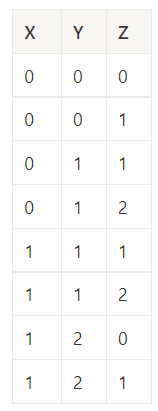

위의 예시에서 X와 Y는 종속적이고, Y와 Z도 종속적이다. 그리고 Y 조건 하에 X와 Z는 독립적이다. 또한 X와 Z는 독립적이다. 그러나 X와 Z는 d-separation이 되어 있지 않다. 

이처럼 ci와 d-separation은 언제나 같이 가지 않는다. 이게 언제나 같이 간다는 가정을 faithfulness 가정이라고 한다. 

d-separation과 관련해서 두 가지 중요한 거 adjacent와 v-structure를 중심으로 생각하면 faithfulness 가정은 그래프에서 이렇게 분리해서 해석할 수 있다.



*   X and Y are adjacent <-> X Y are dependent on any condition
*   uncoupled triple X-Z-Y is v-structure <-> X Y are independent on condition without Z



위의 가정을 adjacent에 대한 faithfulness 가정이라고 할 수 있고, 아래의 가정을 triple에 대한 가정이라고 할 수 있다. 이런 구분은 CPC의 핵심이기도 하다.